<a href="https://colab.research.google.com/github/tommyEzreal/study_low_level/blob/main/NLP/%EB%B0%91%EB%B0%94%EB%8B%A5%EB%B6%80%ED%84%B0%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94%EB%94%A5%EB%9F%AC%EB%8B%9D2/chapter03/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/WegraLee/deep-learning-from-scratch-2

fatal: destination path 'deep-learning-from-scratch-2' already exists and is not an empty directory.


In [2]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [3]:
import numpy as np

# inference approach

basic wor2vec implementation

fundamental probelm of statistical based approach
    - large corpus size and complexity




- batch vs mini-batch

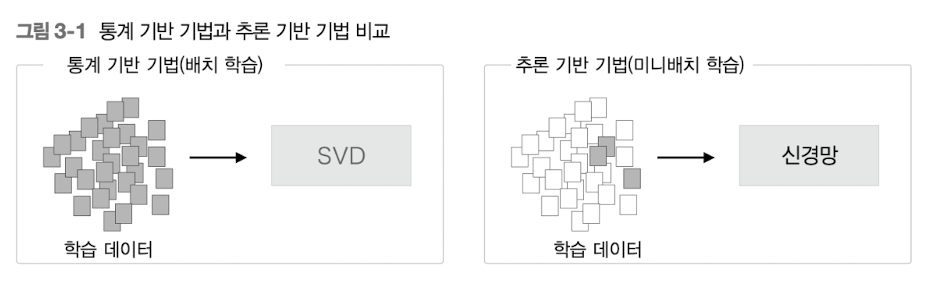

train model with neural net to infer word occurence probability  

print word prob by ***Sequence***

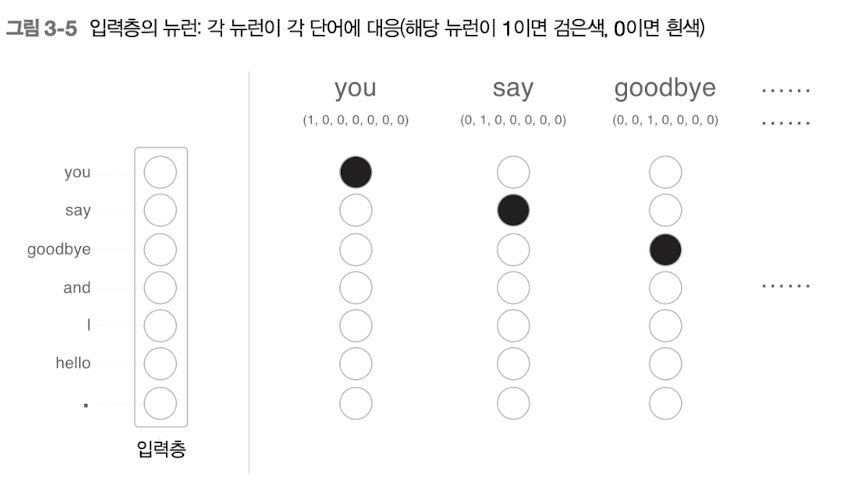


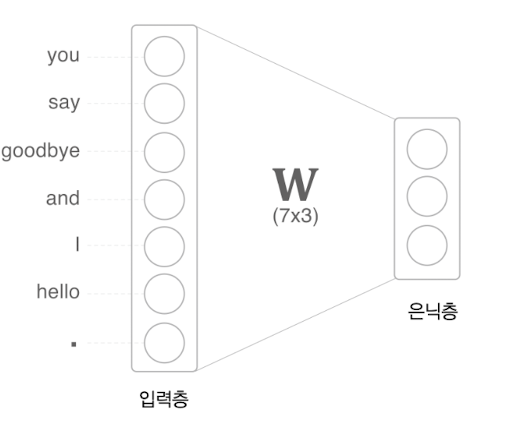

In [4]:
C = np.array([1,0,0,0,0,0,0]) # input
W = np.random.randn(7,3) # Weight (random value)
h = np.matmul(C,W) # weighted sum to calculate next node value 
                    # hidden layer

print(C.shape)
print(W.shape)
print(h)

(7,)
(7, 3)
[-1.13178849 -1.31173459 -2.04136738]


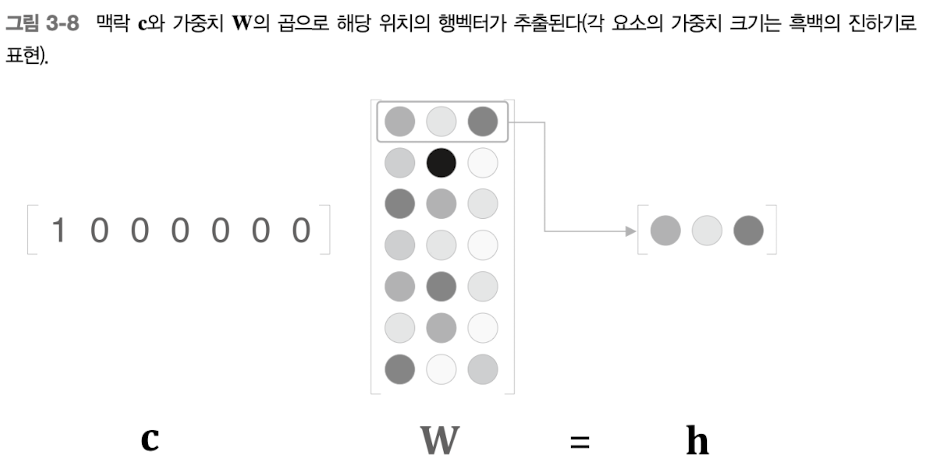

In [5]:
print(C) # one word vec 'You'
print(W) # Weight matrix to pick up 

[1 0 0 0 0 0 0]
[[-1.13178849 -1.31173459 -2.04136738]
 [-1.41122576  1.30997181  1.13459238]
 [ 1.34983806 -1.65954144  0.79849778]
 [-1.08780378 -1.06356091 -0.03078954]
 [ 0.62324522  1.23635871 -0.8277404 ]
 [ 1.12634213  0.74961869 -0.04835121]
 [ 0.8260513  -1.59166994  0.10760466]]


In [6]:
import sys
sys.path.append('..')
from common.layers import MatMul

layer = MatMul(W)
h = layer.forward(C)
print(h)

[-1.13178849 -1.31173459 -2.04136738]


**Simple Word2Vec** 

CBOW 

- infer target(mid word) from context
- inputs = context 
- turn contexts into one-hot vector

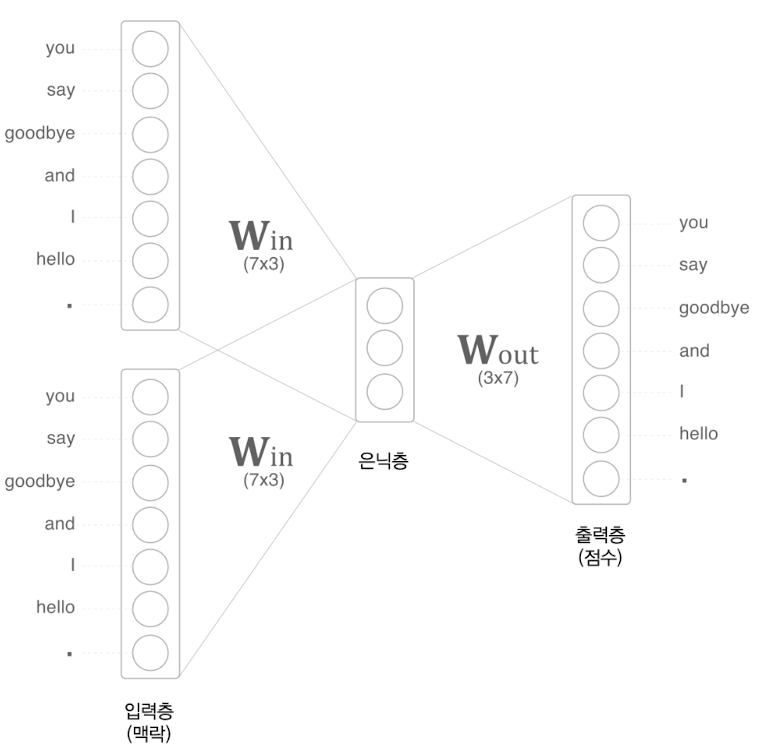

N = 2 (맥락으로 고려할 단어의 수) = num input layer 

hidden_layer = (input_1+ input_2 + ..input_n)/N

- each node corresponds to each word 

- each row of W corresponds to each word's dist representation

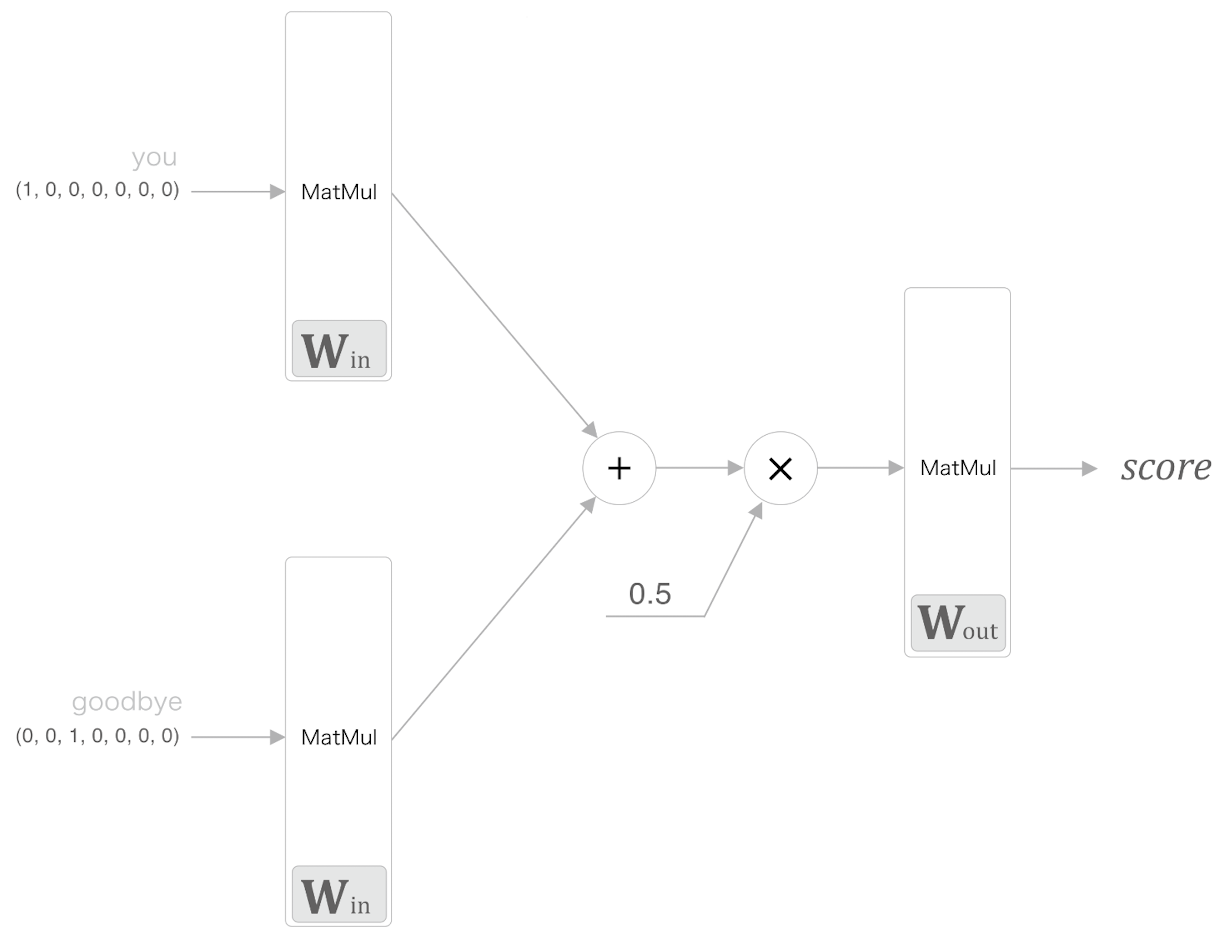

In [7]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        self.grads[0][...] = dW 
        return dx

In [8]:
# CBOW model's inference process

import sys
sys.path.append('...')
from common.layers import MatMul

# sample context vectors / two inputs 
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# weight default
W_in = np.random.randn(7,3) # hidden node 3 
W_out = np.random.randn(3,7)

# layers (Use MatMul class)
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#forward
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0+h1) # mean of two input 
s = out_layer.forward(h)

print(s)
print(s.shape)

[[ 2.60546695  1.91183608  1.62838631  1.89243002 -0.53837273  0.47491999
   0.31314565]]
(1, 7)


In [9]:
for i, score in enumerate(s[0]):
    print(f'{i+1}th word score: {score}')

1th word score: 2.605466954931977
2th word score: 1.9118360761935311
3th word score: 1.628386311242555
4th word score: 1.892430021221074
5th word score: -0.5383727296887799
6th word score: 0.47491999256954337
7th word score: 0.3131456493957179


training CBOW

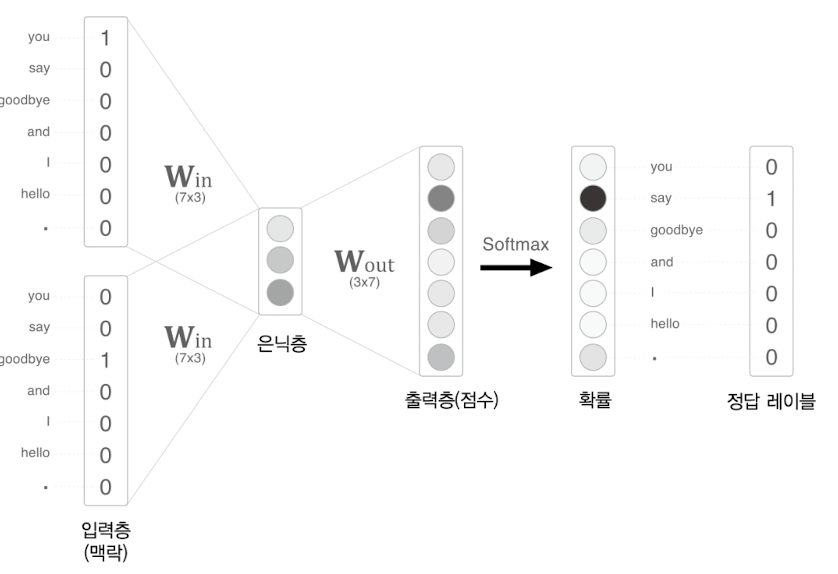

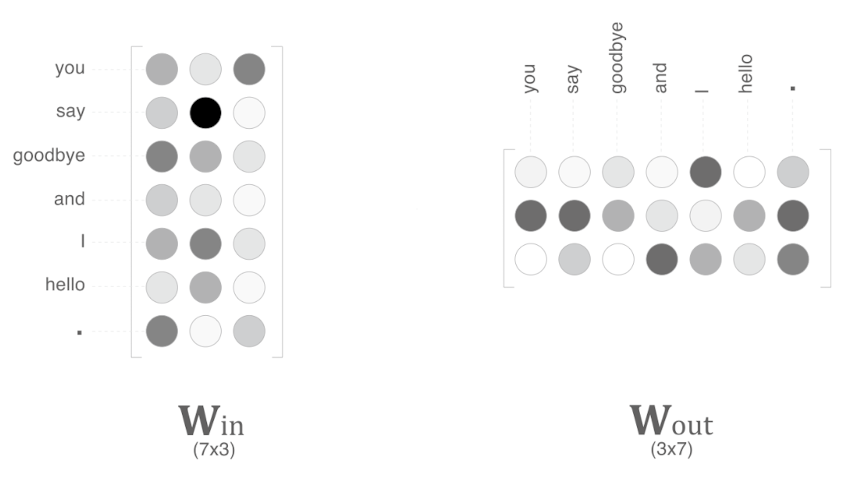

train data

- contexts & target
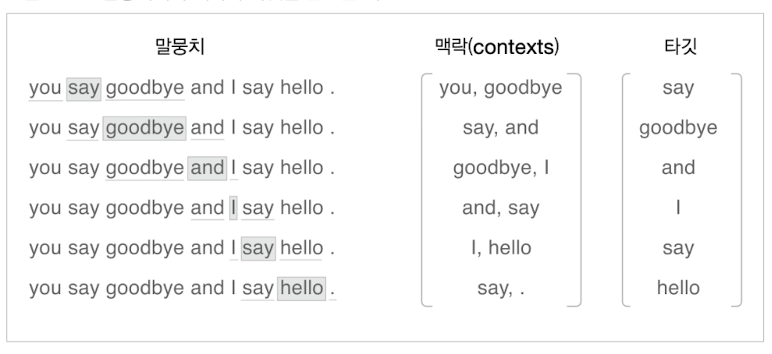

In [10]:
import sys
sys.path.append('...')
from common.util import preprocess

text = 'You say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print("corpus:", corpus)
print('id_to_word:', id_to_word)

corpus: [0 1 2 3 4 1 5 6]
id_to_word: {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [11]:
# from corpus, return contexts and target 

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size: -window_size]
    
    contexts = []
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t==0:
                continue
            cs.append(corpus[idx]+t)
        contexts.append(cs)
    return np.array(contexts), np.array(target)
            

In [12]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts) # by window_size, each contexts of target sequence

print(target) # target sequence 


[[0 2]
 [1 3]
 [2 4]
 [3 5]
 [0 2]
 [4 6]]
[1 2 3 4 1 5]


In [13]:
print(contexts.shape, target.shape)
print(contexts.ndim, target.ndim)

(6, 2) (6,)
2 1


In [14]:
# word idx into one hot

def convert_one_hot(corpus, vocab_size):
    """
    corpus: word id list 
    """

    N = corpus.shape[0] # shape = (batch, sequence), N=sequence

    if corpus.ndim == 1: # for target vector
        one_hot = np.zeros((N, vocab_size), dtype=np.int32) # sequence,vocab_size matrix
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1 # [seuqence, word_id]
    
    elif corpus.ndim ==2: # for context vectors of target 
        C = corpus.shape[1] # dim 
        one_hot = np.zeros((N,C,vocab_size), dtype=np.int32) #(dim, seq, vocab)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1 #
    return one_hot

In [15]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [16]:
print(contexts)
print(target)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0]]

 [[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 0 1]]]
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [17]:
contexts[:,0]

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0]], dtype=int32)

In [18]:
# CBOW 

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss



# what's the word between contexts? 

class CBOW:
    def __init__(self, vocab_sie, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(H,V).astype('f')

        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        """
        num MatMul layer : window size 
        """
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [],[]
        for layer in layers: # for each layer get params in list
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in
        

    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0]) # front contexts 
        h1 = self.in_layer1.forward(contexts[:,1]) # back contexts 
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss 

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None


In [19]:
# trainer

import sys
sys.path.append('..')
import numpy
import time
import matplotlib.pyplot as plt
from common.np import *
from common.util import clip_grads


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch = 10, batch_size =32, max_grad=None, eval_interval = 20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval #do evaluation interval 

        model, optimizer = self.model, self.optimizer
        
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # shuffle data idx 
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters): # iteration
                batch_x = x[iters*batch_size : (iters+1)*batch_size] #slice by batch size 
                batch_t = t[iters*batch_size : (iters+1)*batch_size]

                loss = model.forward(batch_x, batch_t) # to forward pass of model
                model.backward() #backward grad 
                params, grads = remove_duplicate(model.params, model.grads)
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count +=1

                if (eval_interval is not None) and (iters % eval_interval) ==0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('epoch %d | iteration %d/%d | time %d[s] | loss %.2f'
                    % (self.current_epoch+1, iters+1, max_iters, elapsed_time, avg_loss ))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0,0
            
            self.current_epoch += 1


    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iteration (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads     

epoch 1 | iteration 1/2 | time 0[s] | loss 1.95
epoch 2 | iteration 1/2 | time 0[s] | loss 1.95
epoch 3 | iteration 1/2 | time 0[s] | loss 1.95
epoch 4 | iteration 1/2 | time 0[s] | loss 1.95
epoch 5 | iteration 1/2 | time 0[s] | loss 1.95
epoch 6 | iteration 1/2 | time 0[s] | loss 1.95
epoch 7 | iteration 1/2 | time 0[s] | loss 1.95
epoch 8 | iteration 1/2 | time 0[s] | loss 1.95
epoch 9 | iteration 1/2 | time 0[s] | loss 1.94
epoch 10 | iteration 1/2 | time 0[s] | loss 1.94
epoch 11 | iteration 1/2 | time 0[s] | loss 1.94
epoch 12 | iteration 1/2 | time 0[s] | loss 1.94
epoch 13 | iteration 1/2 | time 0[s] | loss 1.94
epoch 14 | iteration 1/2 | time 0[s] | loss 1.94
epoch 15 | iteration 1/2 | time 0[s] | loss 1.94
epoch 16 | iteration 1/2 | time 0[s] | loss 1.94
epoch 17 | iteration 1/2 | time 0[s] | loss 1.94
epoch 18 | iteration 1/2 | time 0[s] | loss 1.94
epoch 19 | iteration 1/2 | time 0[s] | loss 1.94
epoch 20 | iteration 1/2 | time 0[s] | loss 1.94
epoch 21 | iteration 1/2 | ti

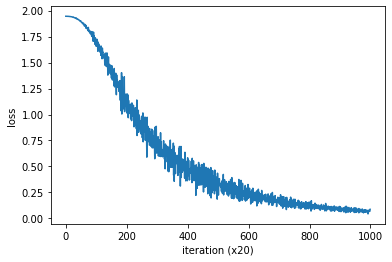

you [-1.2562939   0.86225456 -0.87736803 -0.89948106  1.3889499 ]
say [-1.5686178 -0.8964751  0.8905675  1.0824338  0.7611541]
goodbye [-0.6218257  1.1614591 -1.1802555 -1.5728273  0.4853824]
and [-0.24587578 -1.1143676   1.0754962   1.2098821   1.1725737 ]
i [ 1.6150094   1.2319915  -1.1936237  -0.01347333 -1.5035355 ]
hello [ 1.6821632  -0.9483729   0.9236517   0.92579305  1.161718  ]
. [ 1.1494564   0.8359816  -0.8219195   1.5862745  -0.98430586]


In [20]:
import sys
sys.path.append('..')
from common.optimizer import Adam
from common.util import preprocess

if __name__ == '__main__':
    window_size = 1
    hidden_size = 5
    batch_size = 3
    max_epoch = 1000

    text = 'You say goodbye and I say hello.'
    # make corpus, word_id index 
    corpus, word_to_id, id_to_word = preprocess(text)

    vocab_size = len(word_to_id)
    # make contexts, target vectors(array) 
    contexts, target = create_contexts_target(corpus, window_size)
    # make arrays into onehot representation
    target = convert_one_hot(target, vocab_size)
    contexts = convert_one_hot(contexts, vocab_size)

    #load model & trainer
    model = CBOW(vocab_size, hidden_size)
    optimizer = Adam() # common.optimizer 
    trainer = Trainer(model,optimizer)

    #train
    trainer.fit(contexts, target, max_epoch, batch_size)
    trainer.plot()

    # dense representation of words 
    word_vecs = model.word_vecs
    for word_id, word in id_to_word.items():
        print(word, word_vecs[word_id])
    

In [21]:
word_vecs

array([[-1.2562939 ,  0.86225456, -0.87736803, -0.89948106,  1.3889499 ],
       [-1.5686178 , -0.8964751 ,  0.8905675 ,  1.0824338 ,  0.7611541 ],
       [-0.6218257 ,  1.1614591 , -1.1802555 , -1.5728273 ,  0.4853824 ],
       [-0.24587578, -1.1143676 ,  1.0754962 ,  1.2098821 ,  1.1725737 ],
       [ 1.6150094 ,  1.2319915 , -1.1936237 , -0.01347333, -1.5035355 ],
       [ 1.6821632 , -0.9483729 ,  0.9236517 ,  0.92579305,  1.161718  ],
       [ 1.1494564 ,  0.8359816 , -0.8219195 ,  1.5862745 , -0.98430586]],
      dtype=float32)

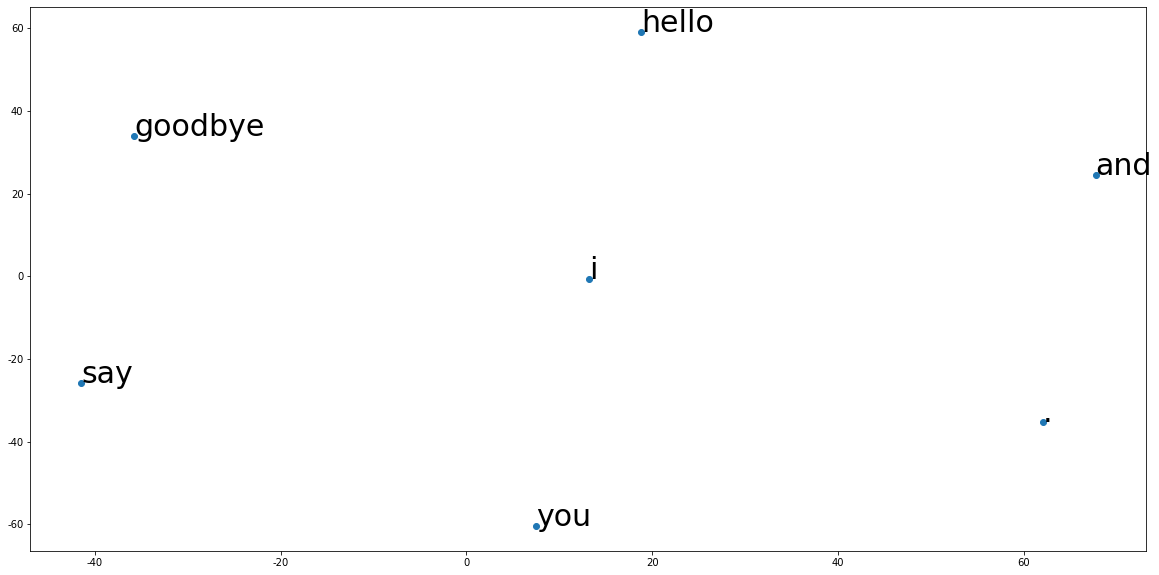

In [22]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

mpl.rcParams['axes.unicode_minus'] = False

tsne = TSNE(n_components=2, perplexity=6.0)

X_tsne = tsne.fit_transform(word_vecs)
vocab = list(id_to_word.values())
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.shape, df.head()
fig = plt.figure()
fig.set_size_inches(20, 10)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()


what actually CBOW model do?

P( target | contexts(front_context, back_context) )

: make loss fct with it.

-> L = -logP(target|contexts). 

-> L = -logP(wt | w(t-1), w(t+1)) # window_size =1   

== Negative Log Likelihood 

##SKIP GRAM

- CBOW : by contexts predict word
- SKIP GRAM : by word predict contexts

- CBOW: P(word | contexts)
- SKIPGRAM: P(contexts | word)

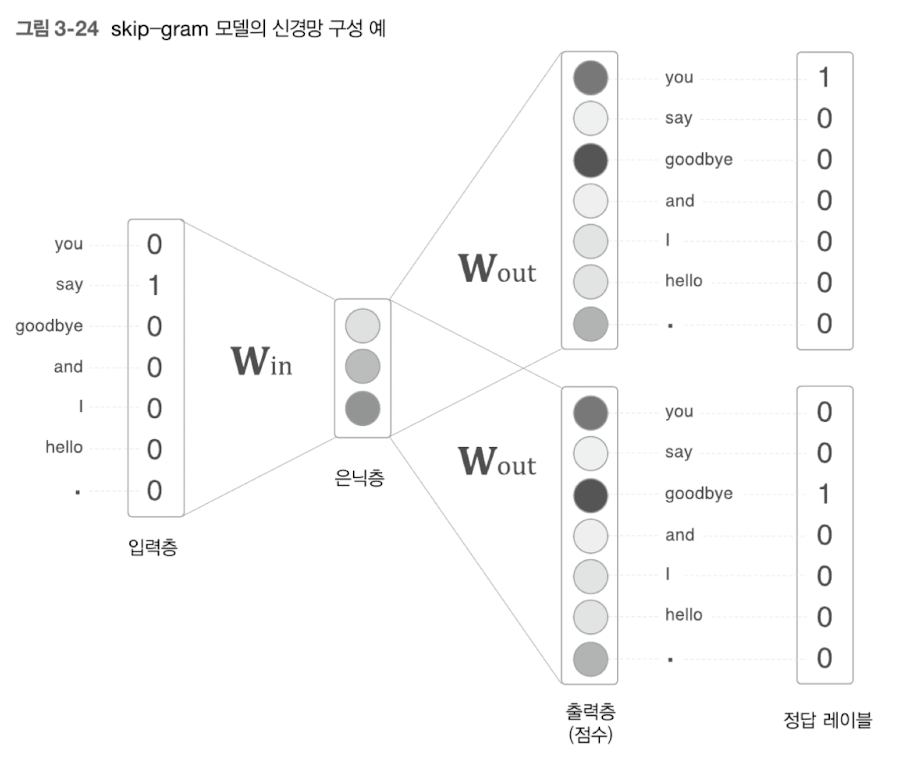

if context_front, context_back are independent, 

P(context_f, context_b | word)   
= P(context_f | word) * P(context_b | word)

into loss fct,  
L = -logP(c_f, c_b | w)  
= -(logP(c_f|w)+logP(c_b|w))

In [23]:
#skip gram

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = 0.01*np.random.randn(V,H).astype('f')
        W_out = 0.01*np.random.randn(H,V).astype('f')

        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss() # for context_front
        self.loss_layer2 = SoftmaxWithLoss() # for context_back

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in
 

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        
        # two loss function for each context
        loss1 = self.loss_layer1.forward(s, contexts[:,0])
        loss2 = self.loss_layer2.forward(s, contexts[:,1])

        loss = loss1+loss2 #optimize two loss 

        return loss

    def backward(self, dout=1):
        dl1= self.loss_layer1.backward(dout)
        dl2= self.loss_layer2.backward(dout)
        ds = dl1 + dl2

        dh = self.out_layer.backward(ds)

        self.in_layer.backward(dh)
        return None





In [24]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

epoch 1 | iteration 1/2 | time 0[s] | loss 3.89
epoch 2 | iteration 1/2 | time 0[s] | loss 3.89
epoch 3 | iteration 1/2 | time 0[s] | loss 3.89
epoch 4 | iteration 1/2 | time 0[s] | loss 3.89
epoch 5 | iteration 1/2 | time 0[s] | loss 3.89
epoch 6 | iteration 1/2 | time 0[s] | loss 3.89
epoch 7 | iteration 1/2 | time 0[s] | loss 3.89
epoch 8 | iteration 1/2 | time 0[s] | loss 3.89
epoch 9 | iteration 1/2 | time 0[s] | loss 3.89
epoch 10 | iteration 1/2 | time 0[s] | loss 3.89
epoch 11 | iteration 1/2 | time 0[s] | loss 3.89
epoch 12 | iteration 1/2 | time 0[s] | loss 3.89
epoch 13 | iteration 1/2 | time 0[s] | loss 3.89
epoch 14 | iteration 1/2 | time 0[s] | loss 3.89
epoch 15 | iteration 1/2 | time 0[s] | loss 3.89
epoch 16 | iteration 1/2 | time 0[s] | loss 3.89
epoch 17 | iteration 1/2 | time 0[s] | loss 3.88
epoch 18 | iteration 1/2 | time 0[s] | loss 3.88
epoch 19 | iteration 1/2 | time 0[s] | loss 3.88
epoch 20 | iteration 1/2 | time 0[s] | loss 3.88
epoch 21 | iteration 1/2 | ti

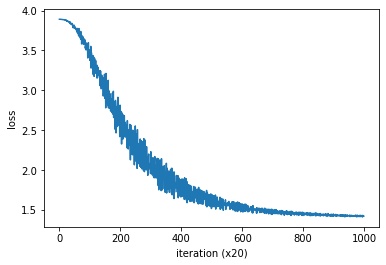

you [-0.01150426  0.00726471  0.01030387 -0.00719196 -0.00588701]
say [ 0.68687606  0.92457783 -0.6774612  -1.0618625   1.0750073 ]
goodbye [-0.98918533 -0.93295616  1.0016971   0.83605427  1.2307577 ]
and [ 1.1422892   1.3034139  -1.1541505   0.4036548  -0.68246764]
i [-0.960166  -0.9405086  0.9854201 -1.2788177 -0.8559377]
hello [ 0.95191705 -1.2110652  -0.9783249   1.0118275  -0.9741009 ]
. [ 0.01232427 -0.0014148  -0.00199913 -0.00558209  0.00015792]


In [25]:
if __name__ == '__main__':
    window_size = 1
    hidden_size = 5
    batch_size = 3
    max_epoch = 1000

    text = 'You say goodbye and I say hello.'
    # make corpus, word_id index 
    corpus, word_to_id, id_to_word = preprocess(text)

    vocab_size = len(word_to_id)
    # make contexts, target vectors(array) 
    contexts, target = create_contexts_target(corpus, window_size)
    # make arrays into onehot representation
    target = convert_one_hot(target, vocab_size)
    contexts = convert_one_hot(contexts, vocab_size)

    #load model & trainer
    model = SkipGram(vocab_size, hidden_size)
    optimizer = Adam() # common.optimizer 
    trainer = Trainer(model,optimizer)

    #train
    trainer.fit(contexts, target, max_epoch, batch_size)
    trainer.plot()

    # dense representation of words 
    word_vecs = model.word_vecs
    for word_id, word in id_to_word.items():
        print(word, word_vecs[word_id])

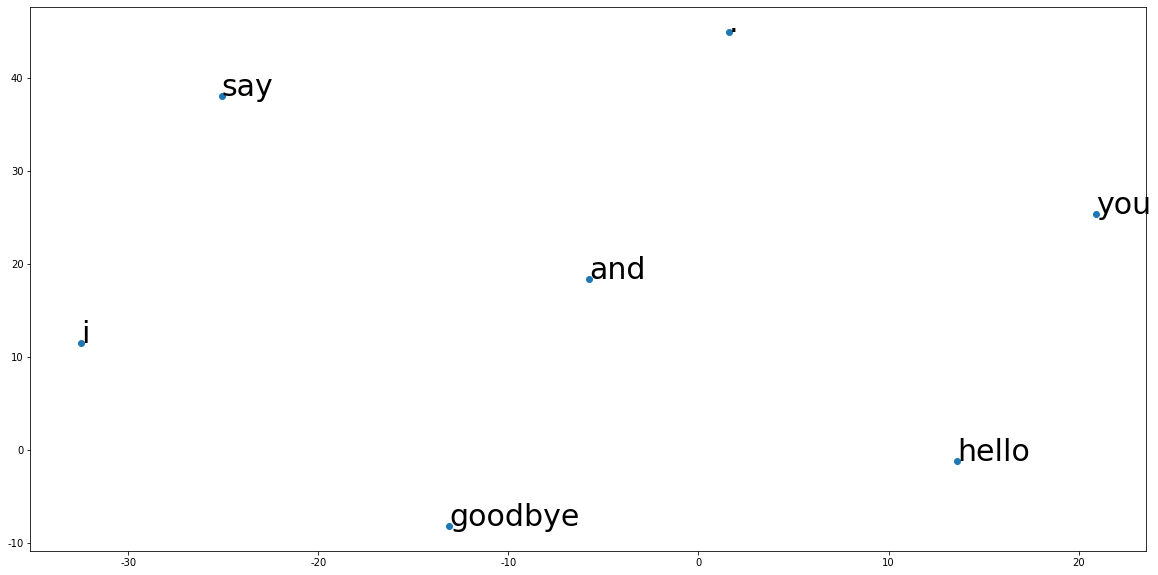

In [27]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

mpl.rcParams['axes.unicode_minus'] = False

tsne = TSNE(n_components=2, perplexity=6.0)

X_tsne = tsne.fit_transform(word_vecs)
vocab = list(id_to_word.values())
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.shape, df.head()
fig = plt.figure()
fig.set_size_inches(20, 10)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()